### はじめに
画像認識のモデル学習には、GPUなどの計算資源を使わないと時間がかかります。Google Colaboratoryは無料でGPUインスタンスを使用可能ですが無料で使えるGPUでの学習は早くなく、90分ルールなどもあります。

## yolov5の学習（minecraftのMobを検出できるようにする）
まずはweb上に公開されているyolov5のリポジトリをコピーして使えるようにする。

**【Google Colaboratoryを使いたい場合】**<br>
先にgoogle driveをマウントして使うと作業が保存されるのでお勧め。以下のコードを実行する。
```
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive
```

In [ ]:
# リポジトリのクローン
!git clone https://github.com/ultralytics/yolov5

In [ ]:
%cd yolov5

# ライブラリのバージョン調整
%pip install -r requirements.txt

### 内容に応じて以下のfilecontensを書き換える
ncがMobの数（クラス数に対応している）
スケルトンやクリーパーを追加学習したい場合はnamesに追記する

In [11]:
# ファイルパス
_filepath = './data/data.yaml'

# ファイルに書き込む内容
filecontents = """
train: data/train/images # 学習の画像のパス
val: data/valid/images # 検証用画像のパス

nc: 2 # (例)学習させるMobの数
names: [ "zombie", "skeleton" ] # (例)学習対象のMob名
"""

# 書き込みモード
with open(_filepath, 'w') as f:
  # ファイル作成、書き込み
  f.write(filecontents)

### 画像の配置
あらかじめ用意していた画像をフォルダ内に配置する。<br>
正しくパスが指定できるならどこに配置してもいい。今回の例では
```yolov5/data/train/images```にスクリーンショットの画像、```yolov5/data/train/labels```にラベル付けした画像を配置している。

フォルダ構造は下記の通りにすると良いです。`data/valid/images`は検証用の画像を配置しますが`data/train/images`と同じものを配置してもいいです。

```
 yolov5
    ┠ data          ← 元からある
      ┠ train       ← 作る
      ┃   ┠ images  ← 作る、ここにスクショを配置
      ┃   ┗ labels  ← 作る、ここにアノテーションした画像を配置
      ┠ valid       ← 作る
          ┗ images  ← 作る
```

### 学習開始
必要に応じてオプションを追加する。
現在のモデルに追加で学習させたい場合は`--weights`にモデルを指定、はじめから構築したい場合は`--cfg`にモデルの原型を指定します。<br>
詳細は下記リンクを参照<br>
[https://qiita.com/shinya_sun_sun/items/8c368f3024bf5b0d14aa](https://qiita.com/shinya_sun_sun/items/8c368f3024bf5b0d14aa)



In [ ]:
!python3 train.py --data data/data.yaml --cfg yolov5n.yaml --weights '' --batch-size 8 --epochs 100 --imgsz 1280 --workers 8

### 結果の確認
下記のコードを実行
```--source ./data/train/images/0322_173.png```といったような画像を指定して結果を確認する。

In [ ]:
!python3 detect.py --weights runs/train/exp/weights/best.pt --conf 0.5 --img-size 640 --exist-ok --source ./data/train/images/1225_114.png

## ONNXモデルへの変換
今のままでは1検出にかかる時間が長いので、CPUのみでの検出に特化した形に変換する。

In [ ]:
# 必要なライブラリのインストール
%pip install onnxruntime
%pip install protobuf==3.19.5
%pip install onnx==1.12.0

In [ ]:
# 変換の開始（best.ptのファイルは自分の環境に合わせてください）
!python3 ./export.py --weights ./runs/train/exp/weights/best.pt --include onnx --img-size 640 --dynamic

### 結果の確認
以下のセルを実行します。ファイル名を任意のパスに変更して、きちんとMobが検出されていればok!

[290.9612, 298.70032, 50.853394, 165.95601]
[291.0133, 300.0216, 48.260094, 178.73846]
[291.7965, 305.1093, 49.123566, 184.35432]
[290.61118, 298.64978, 50.990738, 169.77127]
[292.31146, 299.88425, 49.136005, 178.35938]
[292.3095, 304.92035, 49.16856, 188.90323]
[291.4776, 297.74823, 48.15312, 172.53294]
[291.35922, 302.05753, 50.1386, 172.5265]
[290.8876, 301.84308, 49.62447, 174.3555]
[292.1306, 297.21997, 48.913445, 171.46947]
[291.63406, 303.14502, 50.41668, 173.4156]
[290.66992, 301.06464, 49.649883, 175.88574]


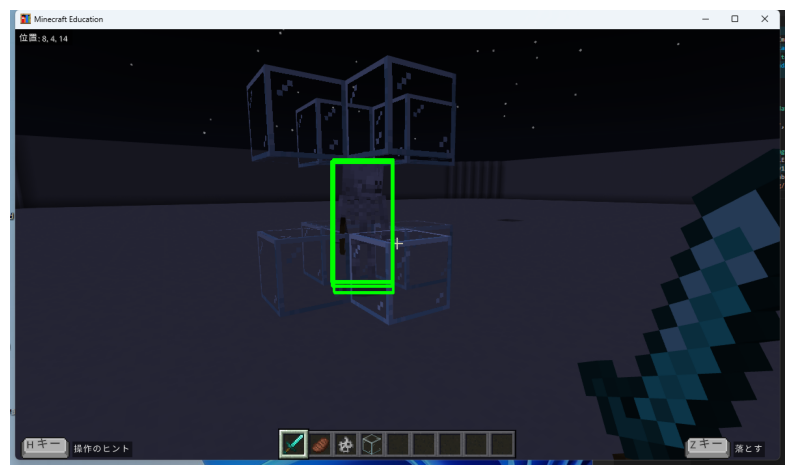

In [17]:
import onnxruntime as ort
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path, input_size=640):
    """画像の読み込みと前処理を行う関数"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (input_size, input_size))
    img_normalized = img_resized / 255.0  # 0-1に正規化
    img_transposed = np.transpose(img_normalized, (2, 0, 1))  # HWC -> CHW
    return np.expand_dims(img_transposed, axis=0).astype(np.float32)


def draw_boxes_on_image(img_path, bboxes, input_size=640):
    """bboxを元の画像上に描画する関数"""
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        # Rescale the bbox to original image size
        x_center = x_center * w / input_size
        y_center = y_center * h / input_size
        width = width * w / input_size
        height = height * h / input_size

        x_min = int(x_center - width / 2.0)
        y_min = int(y_center - height / 2.0)
        x_max = int(x_center + width / 2.0)
        y_max = int(y_center + height / 2.0)
        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green color for boxes

    return img_rgb


def main():
    # ONNXモデルの読み込み
    ort_session = ort.InferenceSession("./runs/train/exp/weights/best.onnx")

    # 画像の前処理
    img_tensor = preprocess_image('./data/train/images/1225_001.png')

    # モデルの推論
    outputs = ort_session.run(None, {'images': img_tensor})
    detections = outputs[0]

    # 検出をbboxes, scores, classesのリストに変換
    bboxes = [list(det[:4]) for det in detections[0] if det[4] > 0.5]
    scores = [det[4] for det in detections[0] if det[4] > 0.5]
    classes = [np.argmax(det[5:]) for det in detections[0] if det[4] > 0.5]

    for i in bboxes:
      print(i)

    # 検出結果を画像上に描画
    result_img = draw_boxes_on_image('./data/train/images/1225_001.png', bboxes)

    # 画像の表示
    plt.figure(figsize=(10,10))
    plt.imshow(result_img)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

### おわりに

これでモデルの作成は終了です！完成した`best.onnx`をボットプログラムの`Minecraft_Contest/python/minecraft/yoloFiles`のなかにある`best.onnx`と差し替えてください